In [2]:
import torch
import torchvision
from PIL import Image

weights = torchvision.models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = torchvision.models.convnext_tiny(weights=weights)

Load the image that we want to predict.

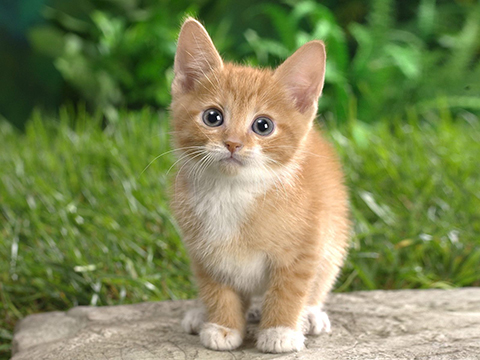

In [3]:
img = Image.open("images/cat.jpg")
display(img)

Do some preprocessing on the image and load all categories.

In [9]:
preprocess = weights.transforms()
categories = weights.meta["categories"]

# preprocess image and add batch dimension
img_transformed = preprocess(img).unsqueeze(0)

output = torch.softmax(model(img_transformed), dim=1)

print(f"Predicted class: {categories[torch.argmax(output)]} ({torch.max(output):.2f})")

Predicted class: tiger cat (0.30)


To inspect the inner workings of the model, we want to extract
all outputs from `Conv2d` modules.
To do this we register a forward hook for every convolution.

In [12]:
activations = {}

def get_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        module.register_forward_hook(get_activation(name))

output = model(img_transformed)

Now we can display any output from a convolution:

In [14]:
list(activations.keys())

['features.0.0',
 'features.1.0.block.0',
 'features.1.1.block.0',
 'features.1.2.block.0',
 'features.2.1',
 'features.3.0.block.0',
 'features.3.1.block.0',
 'features.3.2.block.0',
 'features.4.1',
 'features.5.0.block.0',
 'features.5.1.block.0',
 'features.5.2.block.0',
 'features.5.3.block.0',
 'features.5.4.block.0',
 'features.5.5.block.0',
 'features.5.6.block.0',
 'features.5.7.block.0',
 'features.5.8.block.0',
 'features.6.1',
 'features.7.0.block.0',
 'features.7.1.block.0',
 'features.7.2.block.0']

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


def plot_conv_output(layer_output: torch.Tensor, layer_name: str):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(layer_name, fontsize=16)

    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(12, layer_output.shape[0] // 12),
        axes_pad=0,
    )

    for ax, im in zip(grid, layer_output):
        # Iterating over the grid returns the Axes.
        ax.imshow(im.detach().numpy(), cmap="gray")

    plt.show()

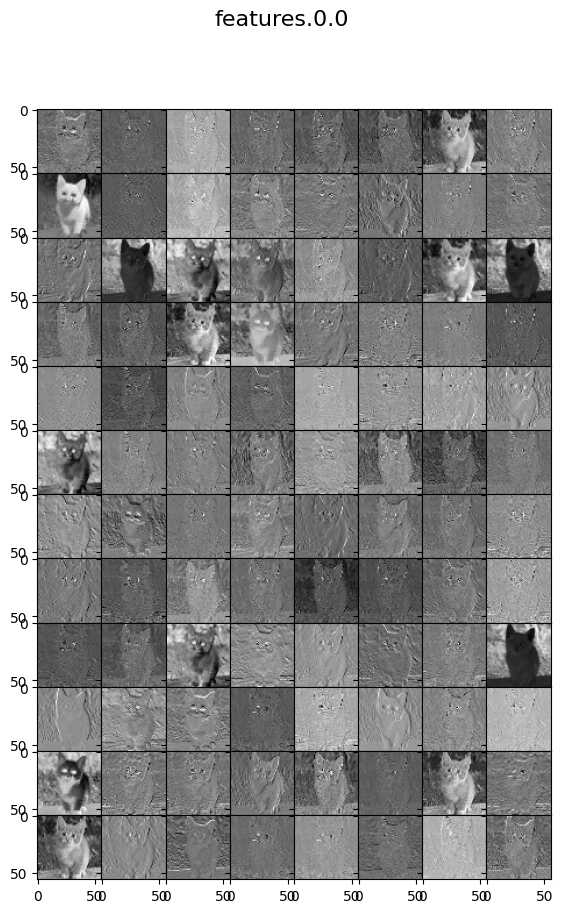

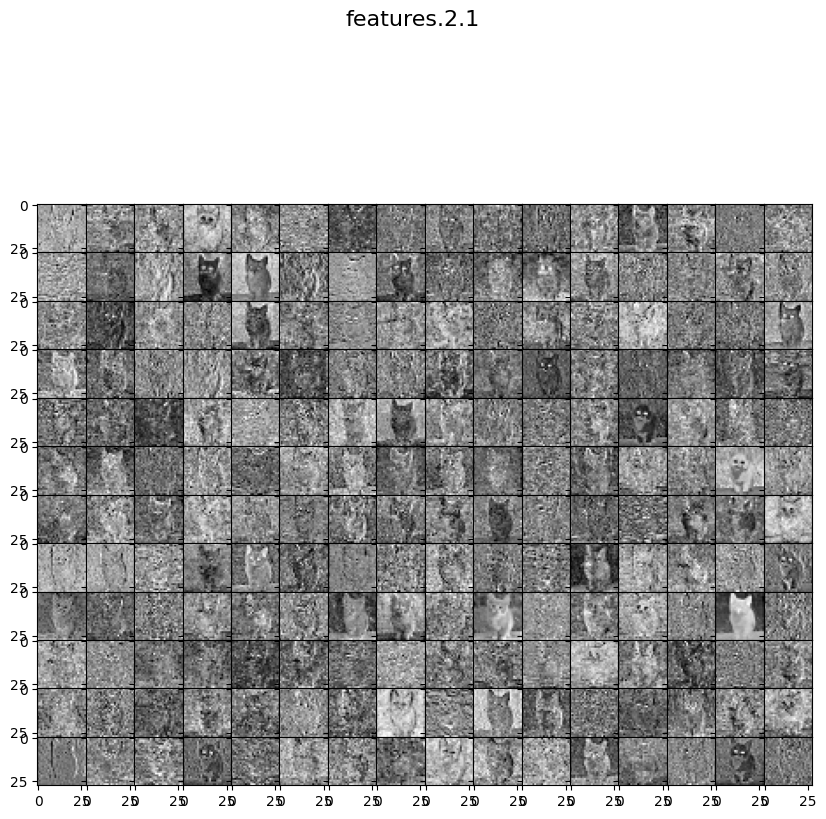

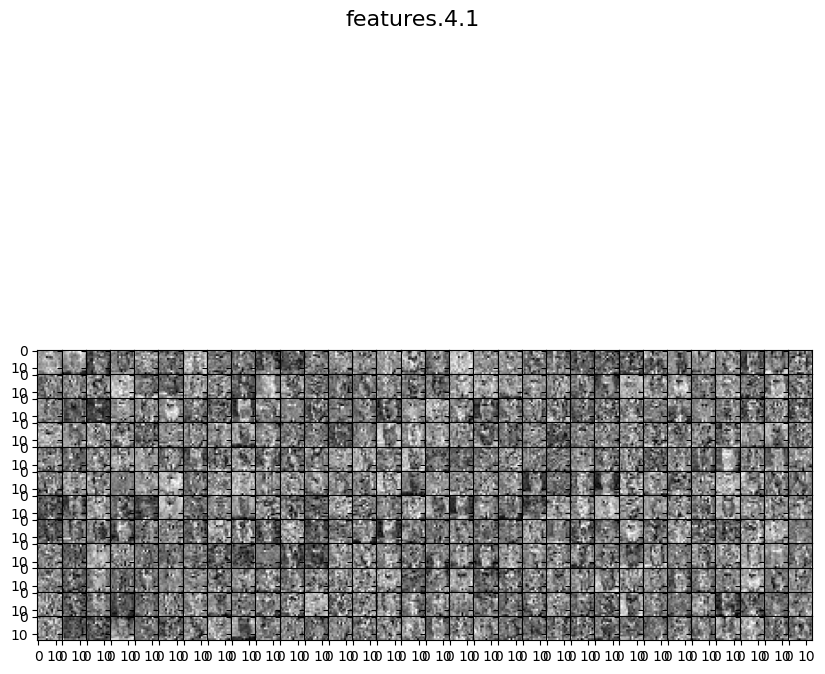

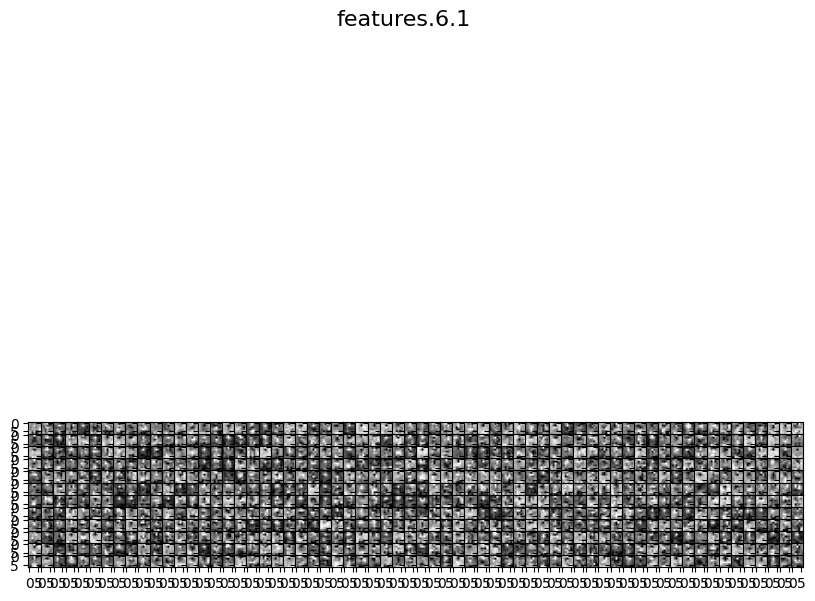

In [24]:
for layer in ["features.0.0", "features.2.1", "features.4.1", "features.6.1"]:
    plot_conv_output(activations[layer].squeeze(0), layer)